<h2>**Problem Definition**</h2>
<p><i>
    Chest pain can be an early indicator of a fatal heart disease, which can be restricted from progression if diagnosed in early stages. Intuition-based analysis of a patients diagnostic reports and health records in order to decide of it is due to a heart desiese or due to some other minor circumstances, has been the traditional way of approaching such cases of chest pain. There is a significant room for enhancing the accuracy, efficiency and reliablity of this process using a data-driven approach, which goes in-hand with the domain experts (Cardiologists).</i> 

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings
import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
def get_95_ci(x1, x2):
    # Calculate the difference of means in the observed data
    signal = x1.mean() - x2.mean()

    # How much data is there? (sample size with len)
    # How consistent is the data (standard deviation with std)
    noise = np.sqrt(x1.std() ** 2 / len(x1) + x2.std() ** 2 / len(x2))

    # Signal plus or minus noise (1.96 relates to 95% confidence level)
    ci_lower_bound = signal - 1.96 * noise
    ci_upper_bound = signal + 1.96 * noise

    return (ci_lower_bound, ci_upper_bound)

<IPython.core.display.Javascript object>

In [5]:
path = "heart.csv"
df_heart = pd.read_csv(path)

rename_map = {
    "cp": "pain_type",
    "trestbps": "rest_bp",
    "fbs": "fast_bp",
    "restecg": "test_ecg",
    "thalach": "max_hr",
    "exang ": "ex_angina",
    "oldpeak": "st_depression",
    "ca": "number_vessels",
    "target": "heart_des",
}

df_heart = df_heart.rename(columns=rename_map)

<IPython.core.display.Javascript object>

<h1><b>Data Cleaning for  any missing (NaN) values</b></h1>

In [6]:
df_heart.isnull().sum()

age               0
sex               0
pain_type         0
rest_bp           0
chol              0
fast_bp           0
test_ecg          0
max_hr            0
exang             0
st_depression     0
slope             0
number_vessels    0
thal              0
heart_des         0
dtype: int64

<IPython.core.display.Javascript object>

<h1><b>CHECK POINT 1 : Exploratory Data Analysis</b></h1>


<h2><b>Questions and Solutions</b></h2>


<b>1. How many people are suffering from heart disease? Also plot the stats. </b>

In [7]:
df_heart["heart_des"].value_counts()

1    165
0    138
Name: heart_des, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
df_heart["heart_des"].value_counts(normalize=True)

1    0.544554
0    0.455446
Name: heart_des, dtype: float64

<IPython.core.display.Javascript object>

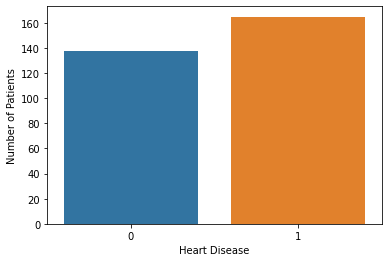

<IPython.core.display.Javascript object>

In [9]:
sns.countplot("heart_des", data=df_heart)
plt.xlabel("Heart Disease")
plt.ylabel("Number of Patients")
plt.show()

<b>2. What is the split up by gender for the patients </b>

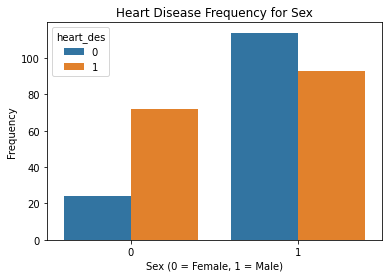

<IPython.core.display.Javascript object>

In [10]:
sns.countplot("sex", hue="heart_des", data=df_heart)
plt.title("Heart Disease Frequency for Sex")
plt.xlabel("Sex (0 = Female, 1 = Male)")
plt.ylabel("Frequency")
plt.show()

<b>3. Visualize frequency distribution of the thalach (max heart rate) variable and find what's the heart rate and heart disease relation?   </b>

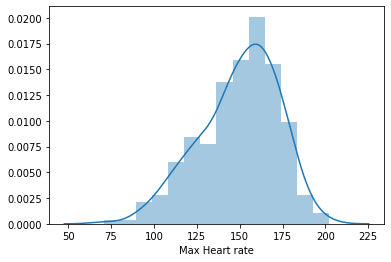

<IPython.core.display.Javascript object>

In [11]:
sns.distplot(df_heart["max_hr"])
plt.xlabel("Max Heart rate")
plt.show()

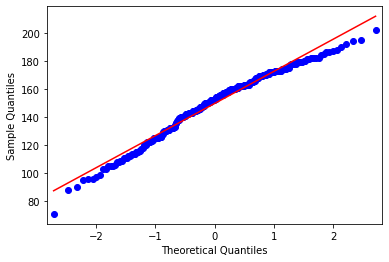

<IPython.core.display.Javascript object>

In [12]:
sm.qqplot(df_heart["max_hr"], line="s")
plt.show()

In [13]:
stats.describe(df_heart["max_hr"])

DescribeResult(nobs=303, minmax=(71, 202), mean=149.64686468646866, variance=524.6464057001726, skewness=-0.5347455419075503, kurtosis=-0.08068888039194055)

<IPython.core.display.Javascript object>

* $H_o:$ Data IS Normal
* $H_a:$ Data IS NOT Normal

*Note: this test is very sensitive to deviations from normality.  With the sample size, qqplot, and skewness/kurtosis metrics, I'd say we're normal enough for most tests.*

In [14]:
t, p = stats.shapiro(df_heart["max_hr"])
p

6.620309432037175e-05

<IPython.core.display.Javascript object>

In [15]:
stats.pearsonr(df_heart["heart_des"], df_heart["max_hr"])

(0.4217409338106744, 1.697337638656172e-14)

<IPython.core.display.Javascript object>

<i>Since the heart desease and max heart rate are positively correlated, chances of Heart Disease increase with increase in heart rate.</i>

<b><i>Hypothesis test of mean heart rate of patients with and without heart Disease</i></b>
<p>
 <li>$H_0:\mu_{HeartRateOfHeart Disease}=\mu_{HeartRateOfNo Heart Disease}$
 <li>$H_0:\mu_{HeartRateOfHeart Disease}!=\mu_{HeartRateOfNo Heart Disease}$
     
<i>Forming two groups and testing for normality of both the groups.</i>
</p>

In [16]:
no_heart_des = df_heart[df_heart["heart_des"] == 0]
yes_heart_des = df_heart[df_heart["heart_des"] == 1]

t1, p1 = stats.shapiro(no_heart_des["max_hr"])
t2, p2 = stats.shapiro(yes_heart_des["max_hr"])

print(f"The p-value for shapiro test of `no_heart_des`: {p1:.4f}")
print(f"The p-value for shapiro test of `yes_heart_des`: {p2:.4f}")

The p-value for shapiro test of `no_heart_des`: 0.4253
The p-value for shapiro test of `yes_heart_des`: 0.0004


<IPython.core.display.Javascript object>

DescribeResult(nobs=138, minmax=(71, 195), mean=139.1014492753623, variance=510.7049613879192, skewness=-0.2935472748025849, kurtosis=-0.23176522769519403)


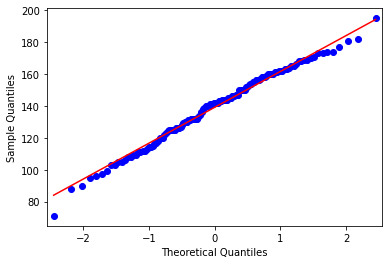

<IPython.core.display.Javascript object>

In [17]:
print(stats.describe(no_heart_des["max_hr"]))
sm.qqplot(no_heart_des["max_hr"], line="s")
plt.show()

DescribeResult(nobs=165, minmax=(96, 202), mean=158.46666666666667, variance=367.65284552845526, skewness=-0.7012606169032712, kurtosis=0.41075760014691554)


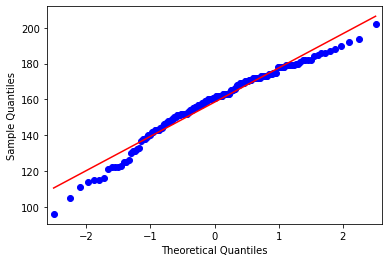

<IPython.core.display.Javascript object>

In [18]:
print(stats.describe(yes_heart_des["max_hr"]))
sm.qqplot(yes_heart_des["max_hr"], line="s")
plt.show()

Both seem normal enough despite shapiro test failing

In [19]:
t, p = stats.ttest_ind(no_heart_des["max_hr"], yes_heart_des["max_hr"])
(t, p)

(-8.069702869452568, 1.697337638656049e-14)

<IPython.core.display.Javascript object>

<i>Since the p-value is less than 0.05, we reject the null and state that <b>The mean heart rates of both the groups is NOT the same</b>.</i>

<i>Now we perform <b>post-hoc analysis</b> to analyse the mean heart rates of both the groups</i>

95% confidence interval of the difference of means is (-24, -15).  This is indicating that the max heart rate for `no_heart_disease` is lower than `yes_heart_des` (by about 20 give or take).

In [20]:
get_95_ci(no_heart_des["max_hr"], yes_heart_des["max_hr"])

(-24.137710597709045, -14.592724184899668)

<IPython.core.display.Javascript object>

<b>4. Find correlation matrix for all the variables with target. </b>

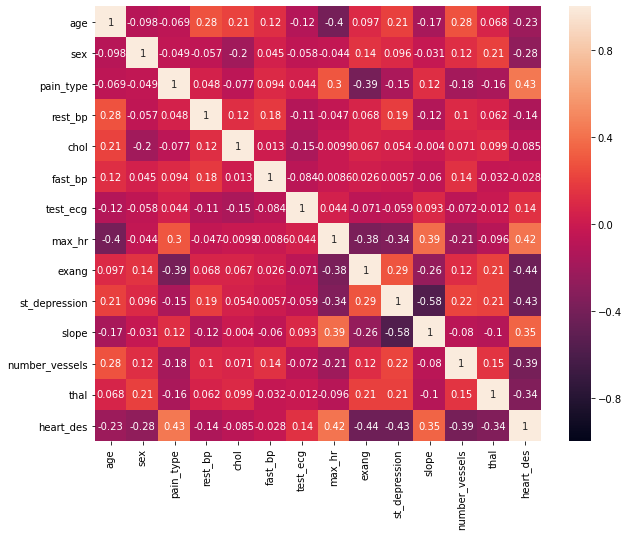

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_heart.corr(), annot=True, vmax=1.0, vmin=-1.0)
plt.show()

In [22]:
heart_des_corrs = df_heart.corr()[["heart_des"]]

# Rename for clarity
heart_des_corrs.columns = ["heart_des_corr"]

# Sort by abs corr to find most powerful correlations + or -
heart_des_corrs["abs_heart_des_corr"] = heart_des_corrs["heart_des_corr"].abs()
heart_des_corrs = heart_des_corrs.sort_values("abs_heart_des_corr", ascending=False)

# Show top
heart_des_corrs.head(7)

,heart_des_corr,abs_heart_des_corr
heart_des,1.000000,1.000000
exang,-0.436757,0.436757
pain_type,0.433798,0.433798
st_depression,-0.430696,0.430696
max_hr,0.421741,0.421741
number_vessels,-0.391724,0.391724
slope,0.345877,0.345877


<IPython.core.display.Javascript object>

<b>5. Find Mean,Min & Max of age and plot its distribution. </b>

In [23]:
df_heart["age"].describe()

count    303.000000
mean      54.366337
std        9.082101
min       29.000000
25%       47.500000
50%       55.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64

<IPython.core.display.Javascript object>

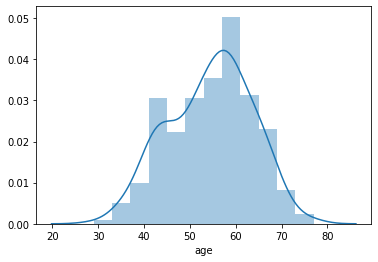

<IPython.core.display.Javascript object>

In [24]:
sns.distplot(df_heart["age"])
plt.show()

<b>6. Age and its relation to heart disease. Is a particular set age of population(say age group 40-50) prone to heart disease than the rest of population age (50+)?  </b>

In [25]:
df_heart[["heart_des", "age"]].groupby("heart_des").mean()

,age
heart_des,
0,56.601449
1,52.496970


<IPython.core.display.Javascript object>

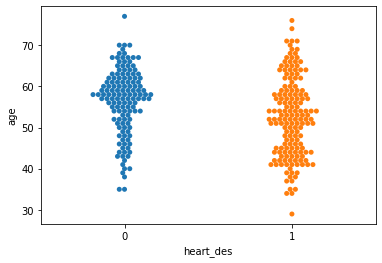

<IPython.core.display.Javascript object>

In [26]:
sns.swarmplot(x="heart_des", y="age", data=df_heart)
plt.show()

Mean and visual seem to show heart disease is less common in older group (sets off alarms for survivor bias in mind, but I have no medical background to back any of that skepticism.

This is also about to be our second statistical test in a span of like 15 cells, we should be thinking about the increase in a chance of a type 1 error. Consider correcting your alpha level for multiple testing (google "statsmodels multiple tests")

Skipping shapiro, too senstive for my taste with these 'large' sample sizes from a traditional stats perspective.

DescribeResult(nobs=165, minmax=(29, 76), mean=52.4969696969697, variance=91.21492978566148, skewness=0.11984858651650541, kurtosis=-0.6334761098775341)


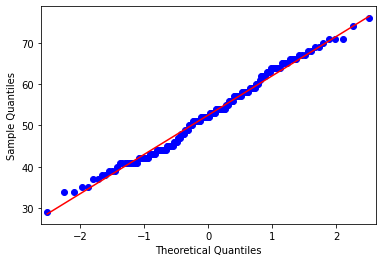

DescribeResult(nobs=138, minmax=(35, 77), mean=56.60144927536232, variance=63.39474240981699, skewness=-0.5425219384500629, kurtosis=0.08111820394037306)


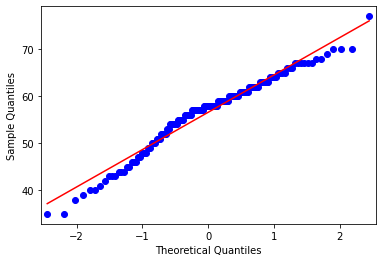

<IPython.core.display.Javascript object>

In [27]:
print(stats.describe(yes_heart_des["age"]))
sm.qqplot(yes_heart_des["age"], line="s")
plt.show()

print(stats.describe(no_heart_des["age"]))
sm.qqplot(no_heart_des["age"], line="s")
plt.show()

In [28]:
t, p = stats.ttest_ind(yes_heart_des["age"], no_heart_des["age"])
(t, p)

(-4.014560975148874, 7.524801303442373e-05)

<IPython.core.display.Javascript object>

<i>Since the p-value is less than 0.05, we reject the null and state that <b>The mean age of both the groups is NOT the same</b>.</i>

<i>Now we perform <b>post-hoc analysis</b> to analyse the mean age of both the groups</i>

In [29]:
get_95_ci(yes_heart_des["age"], no_heart_des["age"])

(-6.076399282361516, -2.132559874423725)

<IPython.core.display.Javascript object>

To view the effects of both `max_hr` and `age` on `heart_des` at once, include in the same model.  The `age` variable is not a significant predictor when included in the same model with `max_hr`.

In [30]:
X = df_heart[["max_hr", "age"]]
y = df_heart["heart_des"]

X_const = sm.add_constant(X)
logit_results = sm.Logit(y, X_const).fit()

logit_results.summary()

Optimization terminated successfully.
         Current function value: 0.590193
         Iterations 5


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              heart_des   No. Observations:                  303
Model:                          Logit   Df Residuals:                      300
Method:                           MLE   Df Model:                            2
Date:                Thu, 16 Jul 2020   Pseudo R-squ.:                  0.1436
Time:                        21:02:16   Log-Likelihood:                -178.83
converged:                       True   LL-Null:                       -208.82
Covariance Type:            nonrobust   LLR p-value:                 9.448e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9264      1.504     -3.276      0.001      -7.874      -1.979
max_hr         0.0413      0.007      6.032      0.000       0.028       0.055
age           -0.0194      0.015     -1.262      0.207      -0.049       0.011
==============================================================================
"""

<IPython.core.display.Javascript object>

[Good quick example of interpreting logistic regression coefficients.](https://stats.stackexchange.com/a/21083/102646)

<b>7. Plot chest pain type pie chart.</b> ...No

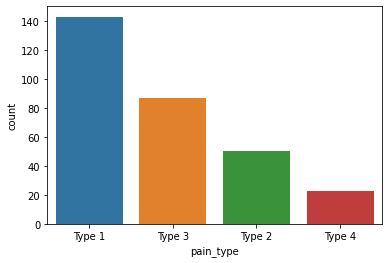

<IPython.core.display.Javascript object>

In [31]:
plot_df = df_heart["pain_type"].value_counts()
plot_df = plot_df.sort_values(ascending=False)
plot_df = plot_df.reset_index()
plot_df.columns = ["pain_type", "count"]

pain_type_map = {0: "Type 1", 1: "Type 2", 2: "Type 3", 3: "Type 4"}
plot_df["pain_type"] = plot_df["pain_type"].replace(pain_type_map)

# set order to be ordered by count (we sorted by count above)
sns.barplot(x="pain_type", y="count", order=plot_df["pain_type"], data=plot_df)
plt.show()

<b>People suffer Type-1 Chest pain more than other types </b>

<b>8. What is the max heart rate achieved in non heart disease patients? 
</b>

In [32]:
no_heart_des["max_hr"].max()

195

<IPython.core.display.Javascript object>

<h1><b>CHECK POINT 2 : Testing various ML Models </b></h1>


<h2><b>Implement different MLs and decide which model fits best</b></h2>


In [33]:
X = df_heart.drop(columns="heart_des")
y = df_heart["heart_des"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

<IPython.core.display.Javascript object>

In [34]:
print_vif(X_train)

VIF results
-------------------------------
const             201.286970
age                 1.475669
sex                 1.246904
pain_type           1.287448
rest_bp             1.170844
chol                1.202035
fast_bp             1.127679
test_ecg            1.056053
max_hr              1.588077
exang               1.427913
st_depression       1.724941
slope               1.547418
number_vessels      1.222578
thal                1.158137
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [35]:
param_grid = [
    {
        # Compare if scaling is better than doing nothing
        "preprocessing": [StandardScaler(), "passthrough"],
        # Compare Logistic Regression vs SVM (both use C param)
        "clf": [LogisticRegression(), SVC()],
        "clf__C": [1, 10, 100, 1000],
    },
    {
        "preprocessing": [StandardScaler(), "passthrough"],
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [20, 50, 100],
        "clf__max_depth": [3, 6, 9],
        "clf__n_estimators": [20, 50, 100],
        "clf__max_features": [0.5, 0.75, 1.0],
    },
]

<IPython.core.display.Javascript object>

In [36]:
# Gonna have the param grid select stuff for us
# LogisticRegression is pretty much a placeholder here, the param grid is gonna swap it out in grid search
pipeline = Pipeline([("preprocessing", "passthrough"), ("clf", LogisticRegression())])

<IPython.core.display.Javascript object>

In [37]:
pipeline_cv = GridSearchCV(pipeline, param_grid, verbose=1)

# Silencing ConvergenceWarnings.. dangerous in case a different important warning comes up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipeline_cv.fit(X_train, y_train)


model = pipeline_cv.best_estimator_
pipeline_cv.best_params_

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:   19.2s finished


{'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=3, max_features=0.5,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=50,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'clf__max_depth': 3,
 'clf__max_features': 0.5,
 'clf__n_estimators': 50,
 'preprocessing': 'passthrough'}

<IPython.core.display.Javascript object>

In [38]:
y_pred = model.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"],
)

display(confusion_df)

print(classification_report(y_test, y_pred))

,Predicted 0,Predicted 1
Actual 0,27,8
Actual 1,5,36


              precision    recall  f1-score   support

           0       0.84      0.77      0.81        35
           1       0.82      0.88      0.85        41

    accuracy                           0.83        76
   macro avg       0.83      0.82      0.83        76
weighted avg       0.83      0.83      0.83        76



<IPython.core.display.Javascript object>